In [91]:
import pandas as pd
import numpy as np
from ast import literal_eval
import pickle
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('TRC_195_16Nov/combined_195.csv')

In [6]:
df.columns

Index(['Unnamed: 0', 'METRAGE', 'Date', 'AC LN', 'AC VT', 'CON F', 'GAUGE',
       'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3',
       'VER L', 'VER R', 'VOLT', 'Track_code', 'Work_orders',
       'Work_order_type', 'culvert', 'speed_description',
       'speed_char_val_from', 'speed_char_val_to', 'speed_value_units',
       'has_wo'],
      dtype='object')

In [7]:
def presence_of_wo(x):
    num_wo = len(literal_eval(x))
    if num_wo >0:
        ans = 1
    else:
        ans = 0
    return ans

df['has_wo'] = df['Work_order_type'].apply(lambda x: presence_of_wo(x))

def morethan1(x):
    if x > 1:
        return 2
    else:
        return x
num_wo = df['Work_orders'].apply(lambda x: len(literal_eval(x)))
df['num_wo'] = num_wo.apply(lambda x: morethan1(x))

In [8]:
def contains_ballast(x):
    workorders = literal_eval(x)
    ans = 0
    for work in workorders:
        if 'ballast' in work.lower():
            ans = 1
    return ans
df['Ballast_work'] = df['Work_order_type'].apply(lambda x: contains_ballast(x))

In [9]:
## test on final two dates
test_set = df.loc[(df['Date']== '2019-05-28') | (df['Date']== '2019-03-05')]
train_set = df.loc[~((df['Date']== '2019-05-28') | (df['Date']== '2019-03-05'))]

In [10]:

df_noB = train_set[train_set['Ballast_work']==0]
df_B = train_set[train_set['Ballast_work']==1]

downsampled_noB = resample(df_noB, replace = True, n_samples = 63341)
downsampled_B = resample(df_B, replace = True, n_samples = 63341)

downsampled_df = pd.concat([downsampled_noB,downsampled_B])

In [14]:
from sklearn.model_selection import train_test_split
measures = ['AC LN', 'AC VT', 'CON F', 'GAUGE', 'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST',
       'TW 10', 'TW 3', 'VER L', 'VOLT']

X_train, X_test, y_train, y_test = train_test_split(downsampled_df[measures], downsampled_df['Ballast_work'], test_size=0.4, random_state=0)

In [39]:

rf = RandomForestClassifier(n_estimators = 20, max_depth= 100).fit(X_train, y_train)
rf_pred = rf.predict(X_train)
rf_acc = metrics.accuracy_score(rf_pred, y_train)
print(rf_acc)

0.999447433856517


In [40]:
rf_test_pred = rf.predict(X_test)
rf_test_acc = metrics.accuracy_score(rf_test_pred, y_test)

print(rf_test_acc)

0.8890730763917668


In [41]:
feat_importance = rf.feature_importances_
indices = np.argsort(feat_importance)[::-1]
print('Sorted feature importance:')
print(sorted(feat_importance, reverse = True))

print('Fetaure number')
print(indices.tolist())

Sorted feature importance:
[0.1337754258266437, 0.132926770707862, 0.1009071227965543, 0.08949595654829005, 0.08936033726036055, 0.06833579271970339, 0.05757547688952704, 0.05355676765338039, 0.05264183303387635, 0.05015743569459088, 0.047873764281864004, 0.04165808567486777, 0.04094301604187119, 0.04079221487060843]
Fetaure number
[13, 5, 6, 12, 3, 2, 4, 9, 10, 1, 0, 11, 7, 8]


In [42]:
measures[13]

'VOLT'

In [45]:
# pickle
rf_out =  open('rf_20_100.pickle','wb')
pickle.dump(rf, rf_out)
rf_out.close()

## now plot

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import geopandas as gpd
import numpy as np
import matplotlib as mpl
from utils import paths
import os

In [50]:
from to_gps_coords import *

In [47]:
## first combine data
infile = open('rf_20_100.pickle', 'rb')
model = pickle.load(infile)
infile.close()

In [49]:
## smoothing function
def smooth_preds(x,thresh):
    if x > thresh:
        ans = 1
    else:
        ans =0
    return ans

In [77]:
pred = model.predict(test_set[measures])
test_set['wo_prediction'] = pred
test_set['wo_prediction_smoothed'] = test_set['wo_prediction'].rolling(10).mean().apply(lambda x: str(smooth_preds(x, 0.5)))

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
gps_data = pd.read_csv(os.path.join(paths.DATA_DERIVED, 'C138_C195_coords.csv'))
to_concat = []
for tc in test_set['Track_code'].unique():
    output = Match_gps(gps_data, test_set[test_set['Track_code'] == tc], track_code = str(tc)[:3]).TRC_to_gps()
    to_concat.append(output)

J:\Shared\OMSA\sem3\DVA\dva_project\src\to_gps_coords.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_to_match['Latitude'] = self.df_to_match['METRAGE'].apply(lambda x: np.interp(x, dist, lat))
J:\Shared\OMSA\sem3\DVA\dva_project\src\to_gps_coords.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_to_match['Longitude'] = self.df_to_match['METRAGE'].apply(lambda x: np.interp(x, dist, long))


In [79]:
comb_df = pd.concat(to_concat)

In [80]:
geometry = [Point(xy) for xy in zip(comb_df['Longitude'], comb_df['Latitude'])] ## state geometry
geo_df = gpd.GeoDataFrame(comb_df, crs = {'init':'epsg:4326'}, geometry = geometry) # create geopandas df
geo_df.columns

Index(['Unnamed: 0', 'METRAGE', 'Date', 'AC LN', 'AC VT', 'CON F', 'GAUGE',
       'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3',
       'VER L', 'VER R', 'VOLT', 'Track_code', 'Work_orders',
       'Work_order_type', 'culvert', 'speed_description',
       'speed_char_val_from', 'speed_char_val_to', 'speed_value_units',
       'has_wo', 'num_wo', 'Ballast_work', 'wo_prediction',
       'wo_prediction_smoothed', 'Latitude', 'Longitude', 'geometry'],
      dtype='object')

In [131]:
geo_df.head()

,Unnamed: 0,METRAGE,Date,AC LN,AC VT,CON F,GAUGE,GR HT,OV HT,SUPER,...,speed_char_val_to,speed_value_units,has_wo,num_wo,Ballast_work,wo_prediction,wo_prediction_smoothed,Latitude,Longitude,geometry
235,235,207.013,2019-05-28,0.1,0.3,-46.9,1067.0,7.4,774.0,3.5,...,NaN,NaN,0,0,0,0,0,-25.950832,152.542934,POINT (152.54293 -25.95083)
253,253,207.014,2019-05-28,0.6,0.4,-46.9,1067.5,6.6,774.8,2.3,...,NaN,NaN,0,0,0,0,0,-25.950823,152.542938,POINT (152.54294 -25.95082)
271,271,207.015,2019-05-28,0.5,0.4,-46.3,1067.5,5.8,775.9,3.1,...,NaN,NaN,0,0,0,0,0,-25.950815,152.542942,POINT (152.54294 -25.95081)
289,289,207.016,2019-05-28,0.5,0.3,-42.6,1066.0,4.0,769.9,3.4,...,NaN,NaN,0,0,0,0,0,-25.950806,152.542946,POINT (152.54295 -25.95081)
307,307,207.017,2019-05-28,0.5,0.4,-40.9,1067.0,3.4,768.8,2.0,...,NaN,NaN,0,0,0,0,0,-25.950798,152.542950,POINT (152.54295 -25.95080)


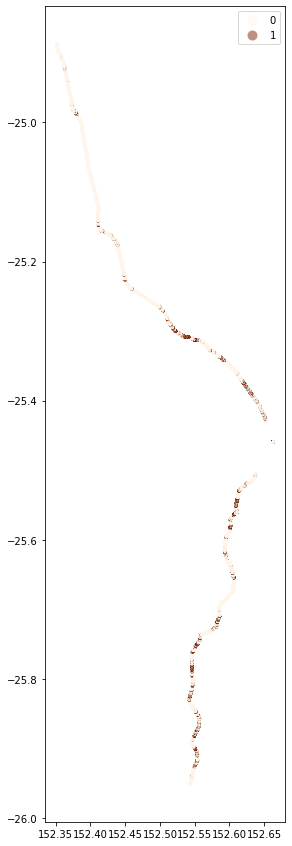

In [90]:
## plot lines according to subdivision
fig,ax = plt.subplots(figsize = (15,15))
geo_df.plot(ax = ax, column = 'wo_prediction_smoothed', markersize = 4, cmap = 'Oranges', legend = True, alpha = 0.5)

In [130]:
test_set['wo_prediction_smoothed'] = test_set['wo_prediction_smoothed'].astype(float)
test_set.reset_index().groupby(['Date', 'Track_code', 'METRAGE'])['wo_prediction_smoothed'].mean().round()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Date        Track_code  METRAGE
2019-03-05  728001      263.277    0.0
                        263.278    0.0
                        263.279    0.0
                        263.280    0.0
                        263.281    0.0
                                  ... 
2019-05-28  729001      348.896    0.0
                        348.897    0.0
                        348.898    0.0
                        348.899    0.0
                        348.900    0.0
Name: wo_prediction_smoothed, Length: 227308, dtype: float64

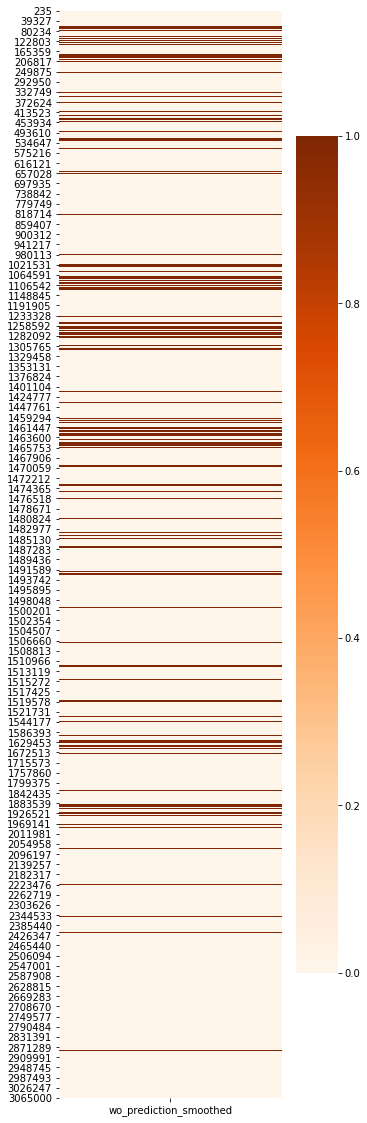

In [114]:
fig, ax = plt.subplots(figsize = (5,20))
test_set.set_index('METRAGE')
ax = sns.heatmap(test_set[['wo_prediction_smoothed']].astype(float), cmap = 'Oranges')
plt.show()